In [2]:
import io
import os
import base64

import numpy as np
import pandas as pd
from tqdm.cli import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, no_update, callback

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
from transformers import ViTImageProcessor, ViTModel
sns.set_theme(style="darkgrid", palette="Set2")

---
### Задача 1.

Докажите, что метод KMeans делит все пространство объектов на выпуклые многоугольники, возможно, неограниченные.

Рассмотрим случай $\mathbb R^2$:

Проведем срединные перепендикуляры для всех отрезков, соединяющих каждые центры попарно. Рассмотрим пару центров $(\mu_i, \mu_j)$. Рассмотрим срединный перпендикуляр к отрезку, соединяющему их центры. Из соображений симметрии ясно, что все точки по одну сторону от перепендикуляра к отрезку, соединяющему их, будут ближе к $\mu_i$, по другую -- к $\mu_j$.

Тогда кластером для $\mu_i$ будет пересечение всех таких полуплоскостей для всех пар $(\mu_i, \mu_x)$. Так как полуплоскости являются выпуклым множеством, то их пересечение также будет выпукло. Оно также будет являться многоугольником, так как его границы прямые.

В случае $\mathbb R^n$ рассуждения будут аналогичны, просто теперь будут гиперплоскости размерности $\mathbb R^{n-1}$, которые будут сторонами выпуклого многоугольника.

---
### Задача 2.

Как мы знаем из <a href="https://miptstats.github.io/courses/ad_fivt/lecture8.pdf">лекции</a>, в пространствах большой размерности расстояния между случайными объектами становятся неинформативными. Эта проблема известна как *проклятие размерности*, и она влечет соответствующие ограничения на использование методов, основанных на использовании расстоянии между объектами.

В этой задаче предлагается промоделировать ситуацию понижения размерности. Сгенерируйте достаточно большое количество точек в единичном кубе в пространстве некоторой размерности. Пример кода дан ниже

In [ ]:
sample_size = 1000
dimention = 100
sample = np.random.uniform(size=(sample_size, dimention))

Повторите генерацию для нескольких размерностей пространства от 2 до 1000. Используйте не менее 7 различных значений размерностей пространства.

In [ ]:
samples = [np.random.uniform(size=(sample_size, i)) for i in range(2, 1000, 100)]

Для каждой размерности посчитайте норму каждой точки, тем самым получая набор значений расстояния от 0 до случайной точки. Нормируйте все расстояния, поделив на среднее полученных расстояний для каждой размерности пространства.

In [ ]:
norms = []
for sample in samples:
    values = [np.sqrt(np.sum(i**2)) for i in sample]
    norms.append(values / np.mean(values))

Нарисуйте на одном графике <a href="https://miptstats.github.io/courses/python/09_seaborn.html#3.-Оценки-плотности" target="_blank">KDE-оценки плотности</a> нормированных расстояний для каждой размерности пространства.

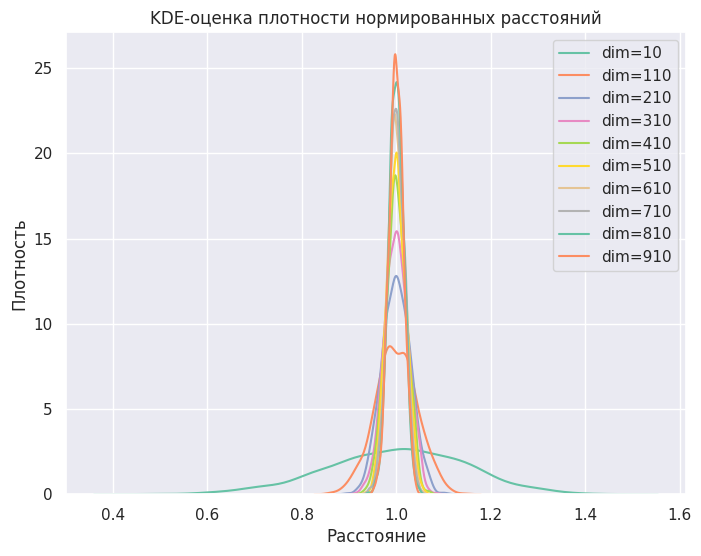

In [ ]:
sample_size = 1000
samples = [np.random.uniform(size=(sample_size, i)) for i in range(10, 1000, 100)]
plt.figure(figsize=(8,6))
norms = []
for i, sample in enumerate(samples):
    values = [np.linalg.norm(x) for x in sample]
    norms.append(values / np.mean(values))
    sns.kdeplot(norms[i], label=f'dim={100*i+10}')

plt.title('KDE-оценка плотности нормированных расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Сделайте выводы

**Вывод:** Из полученного графика можно сделать вывод, что при увеличении размерности разброс данных становится все меньше. Действительно имеет проклятие размерности, данные становятся менее информативными. Это может быть связано с тем, что при увеличении размерности данные становятся все более разрежеными.

---
### Задача 3.

В этой задаче мы попробуем кластеризовать различными способами изображения котиков из датасета с <a href="https://miptstats.github.io/courses/ad_fivt/pca.html" target="_blank">семинара</a>.

Скачайте данные, загрузите их и отрисуйте несколько примеров.

Размерность cats: (15747, 12288)


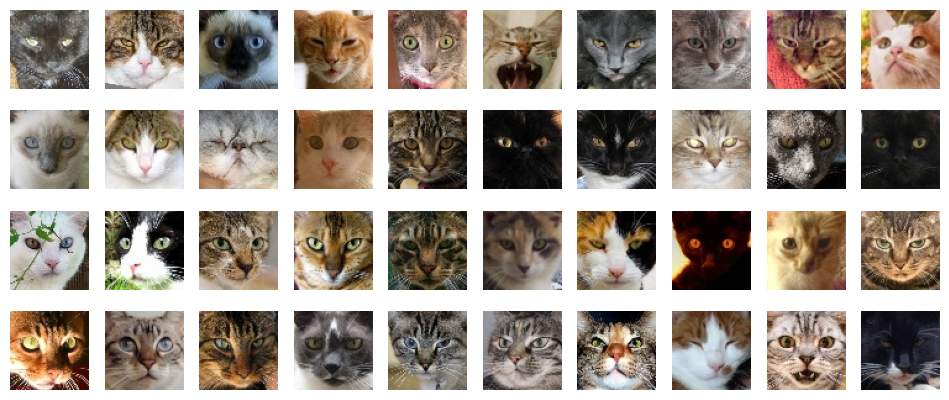

In [4]:
cats_path = "cats"
cats = []

for filename in os.listdir(cats_path):
    cats.append(plt.imread(os.path.join(cats_path, filename)))

cats = np.stack(cats).reshape(-1, 64 * 64 * 3)
print(f"Размерность cats: {cats.shape}")

# Визуализируем примеры
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(cats[i].reshape(64, 64, 3))
    plt.axis("off")

#### 1. Свойства метрики в пространстве котиков

Прежде всего давайте исследуем, наблюдается ли проблема проклятия размерности в пространстве котиков, фактически повторив исследование предыдущей задачи. Для этого выберите не менее 10000 случайных пар изображений и посчитайте расстояния между ними. Визуализируйте <a href="https://miptstats.github.io/courses/python/09_seaborn.html#3.-Оценки-плотности" target="_blank">KDE-оценку плотности</a> нормированных расстояний.

Повторите те же действия к результату применения PCA, рассмотрев разное количество компонент, например, для 30, 100 и 500. Обратите внимание, что PCA нужно обучать на всех изображениях, а не только для тех, для которых вы будете считать расстояния. Примеры обучения PCA можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/pca.html" target="_blank">ноутбуке</a> с занятия.

Составим случайные пары

In [ ]:
num_cats = cats.shape[0]
number_of_pairs = 10000
random_indices = np.random.choice(num_cats, size=(number_of_pairs, 2), replace=True)
random_pairs = [(cats[random_indices[i, 0]], cats[random_indices[i, 1]]) for i in range(number_of_pairs)]

Посчитаем нормированные расстояния для каждой пары и визуализируем их KDE-плотность

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


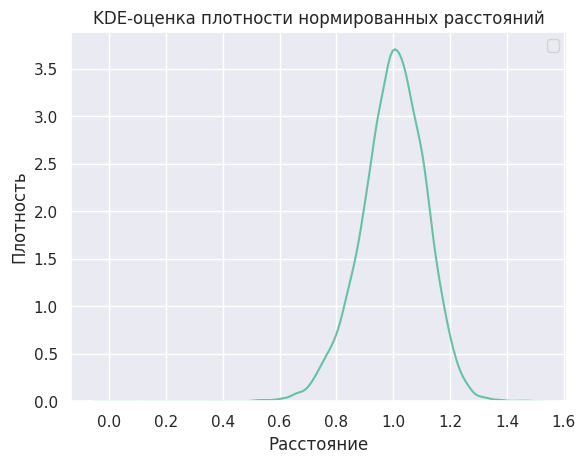

In [ ]:
values = [np.linalg.norm(pair[0] - pair[1]) for pair in random_pairs]
sns.kdeplot(values/np.mean(values))
plt.title('KDE-оценка плотности нормированных расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Получим результаты для PCA

In [ ]:
PCA_components_number = [30, 100, 150]
pca_values = []
for n in PCA_components_number:
    pca = PCA(n_components=n)
    cats_projection = pca.fit_transform(cats.astype(np.float32))

    num_cats = cats_projection.shape[0]
    number_of_pairs = 10000
    random_indices = np.random.choice(num_cats, size=(number_of_pairs, 2), replace=True)
    random_pairs = [(cats_projection[random_indices[i, 0]], cats_projection[random_indices[i, 1]]) for i in range(number_of_pairs)]
    values = [np.linalg.norm(pair[0] - pair[1]) for pair in random_pairs]
    pca_values.append(values/np.mean(values))

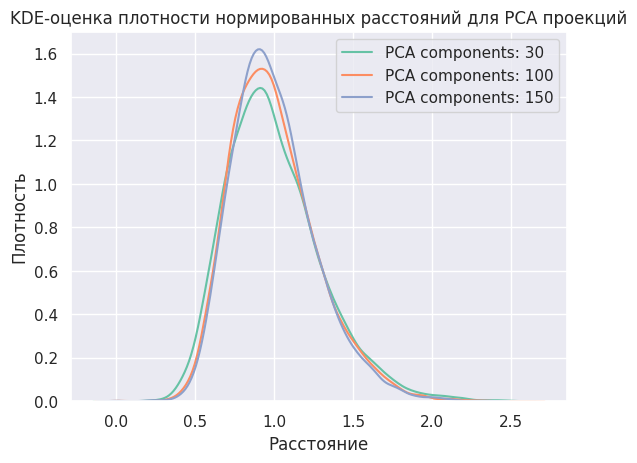

In [ ]:
for i, values in enumerate(pca_values):
    sns.kdeplot(values, label=f'PCA components: {PCA_components_number[i]}')

plt.title('KDE-оценка плотности нормированных расстояний для PCA проекций')
plt.xlabel('Расстояние')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Сделайте выводы

**Вывод:** из полученных графиков видно, что чем больше главных компонент мы берем, тем уже становится сам график. Однако изменения весьма малы, данные для разных размерностей имеют достаточно неплохой разброс, график не вырождается в узкий пик. Так что можем предположить, что проклятия размерностей для котиков нету

#### 2. Кластеризация котиков по вектору изображения

Начнем эксперименты с самого простого способа: каждое изображение можно вытянуть в вектор размерности $64 \cdot 64 \cdot 3$, их и попытаемся кластеризовать. Обучите по этим объектам метод KMeans, пример можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/clustering.html" target="_blank">ноутбуке</a> по кластеризации

In [ ]:
%%time
# Делаем кластеризацию
kmeans = KMeans(n_clusters=4, n_init="auto", random_state=42)
kmeans.fit(cats)
y_pred = kmeans.predict(cats)

CPU times: user 28.1 s, sys: 7.52 s, total: 35.7 s
Wall time: 13.1 s


Теперь отобразим изображения на плоскость с помощью PCA и визуализируем полученные предсказания цветом, как это было сделано на семинаре для ответов на вопросы в бот. Ниже уже реализована функция отрисовки `visualize_images_clusterisation`, вам требуется лишь применить PCA и вызвать функцию с правильными параметрами.

In [5]:
def visualize_images_clusterisation(images, projection, clusters, port=None):
    """
    Визуализиует двумерную проекцию эмбеддингов изображений,
    во всплывающем окне показывает сами изображения

    :param images: набор изображений
    :param projection: двумерная проекция изображений или эмбеддингов изображений
    :param clusters: предсказанные кластера
    :param port: опциональный параметр, порт на котором поднимается визуализация:
                 одинаковые порты - одинаковые графики, но если в ноутбуке открыто много портов, то могут начаться лаги
    """
    # Рисуем график с точками как на семинаре
    fig = px.scatter(
        x=projection[:, 0],
        y=projection[:, 1],
        hover_name=clusters,
        hover_data={"image_idx": list(range(len(images)))},
        color=clusters.astype(str),
        width=1000,
        height=800,
        title="PCA проекция изображений на плоскость",
        size=[1] * len(images),
        size_max=12,
    )

    # Добавляем во всплывающее окошко (hover box) изображения
    fig.update_traces(
        hoverinfo="none",
        hovertemplate=None,
    )

    app = Dash(__name__)

    app.layout = html.Div(
        className="container",
        children=[
            dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-2", direction="bottom"),
        ],
    )

    @callback(
        Output("graph-tooltip-2", "show"),
        Output("graph-tooltip-2", "bbox"),
        Output("graph-tooltip-2", "children"),
        Output("graph-tooltip-2", "direction"),
        Input("graph-2-dcc", "hoverData"),
    )
    def display_hover(hoverData):
        """
        Настраивает всплывающее окно hover box.

        :param hoverData: данные соответствующей точки
        """
        if hoverData is None:
            return False, no_update, no_update, no_update

        # Достаем индекс картинки, который выше положили в hover_data
        hover_data = hoverData["points"][0]
        image_idx = hover_data["customdata"][0]
        # И получаем само изображение кота
        image = Image.fromarray(images[image_idx].reshape(64, 64, 3))

        # Преобразовываем изображение в base64 кодировку
        buffer = io.BytesIO()
        image.save(buffer, format="jpeg")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        image_url = "data:image/jpeg;base64, " + encoded_image

        image_children = [
            html.Img(
                src=image_url,
                style={"width": "196px"},
            ),
        ]

        return True, hover_data["bbox"], image_children, "top"

    if port is None:
        port = str(np.random.randint(5000, 15000))
    app.run(port=port, debug=True, jupyter_height=800)

    return app

In [ ]:
# Делаем проекцию
pca = PCA(n_components=2)
like_nn_projection = pca.fit_transform(cats)

In [ ]:
visualize_images_clusterisation(images=cats, projection=like_nn_projection, clusters=y_pred)

Для каждого кластера нарисуйте по 5-10 типичных изображений, то есть ближайших к центру кластера. Похожую операцию мы видели на занятии в <a href="https://miptstats.github.io/courses/ad_fivt/clustering.html" target="_blank">ноутбуке</a> по кластеризации.

*Примечание.* Для одного кластера рисуйте картинки "в строчку". Так будет удобно как вам самим, так и проверяющему. Примеры можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/pca.html" target="_blank">ноутбуке</a> по PCA.

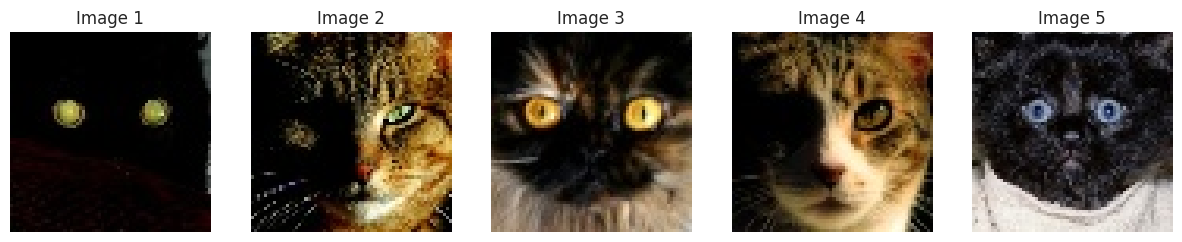

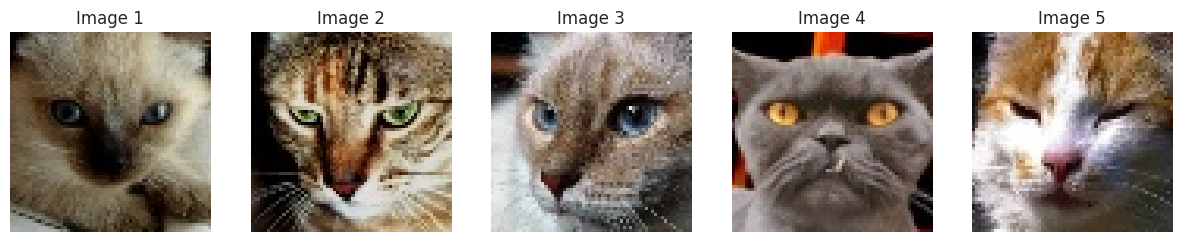

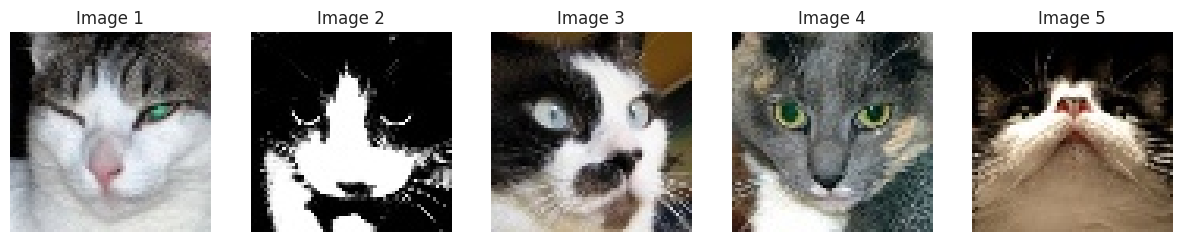

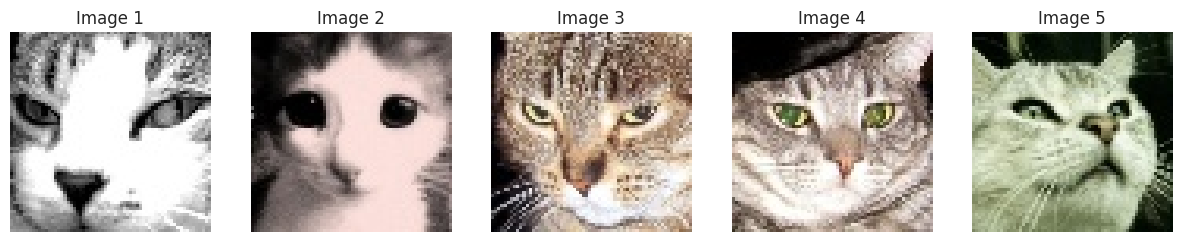

In [ ]:
# Определяем количество столбцов для изображений
num_cols = 5

for cluster in np.unique(y_pred):
    cluster_points = like_nn_projection[y_pred == cluster]
    cluster_answers = cats[y_pred == cluster]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем 5 изображений
    closest_answers = np.unique(cluster_answers[closest_idxs], axis=0)[:5]

    # Создаем новый график с пятью столбцами
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 3))

    # Выводим по 5 изображений для каждого кластера
    for i, im in enumerate(closest_answers):
        ax = axes[i]
        ax.imshow(im.reshape(64, 64, 3))
        ax.axis('off')  # Выключаем оси
        ax.set_title(f'Image {i+1}')  # Заголовок для каждого изображения

    plt.show()  # Показываем график после вывода всех изображений


Наблюдаются ли какие-то закономерности в изображениях внутри одного кластера? Если да, то опишите отличительные черты кластеров.

Из полученных графиков получаем следующие ярко-выраженные черты у котиков для каждого кластера:

-- в 1 кластере в основном котики с темным окрасом, либо находящиеся в темноте

-- во 2 кластере в основном котики либо с рыжим окрасом, либо с полосатые

-- в 3 кластере в основном котики с белым пятном на мордочке или шее

-- в 4 кластере в основном котики с светло-серым или белым окрасом

Подумайте, чем может быть плох такой подход? Какая проблема могла возникнуть и возникла ли? Обратите внимание на проведенное ранее исследование.

Если бы пространство котиков было подвержено проклятию размерностей, то расстояние между двумя картинками было бы неинформативным. Поэтому для вычленения информативных результатов пришлось бы понижать размерность пространства (например, использовать PCA для вычленения главных компонент).

Поскольку в предыдущем пункте мы сделали вывод, что для нашего пространства такой проблемы по сути нет, то в целом нас удволетворяет данный подход (в чем мы еще раз убедимся в следующем пункте).

#### 3. PCA + кластеризация

Попробуем уменьшить размерность перед кластеризацией с помощью PCA, спроектировав изображения на первые несколько главных компонент

**Примечание.** Не стоит брать больше 100 главных компонент

Сделайте кластеризацию:

In [ ]:
%%time
pca = PCA(n_components=100)
cats_projection = pca.fit_transform(cats.astype(np.float32))

kmeans = KMeans(n_clusters=4, n_init="auto", random_state=42)
kmeans.fit(cats_projection)
y_pred = kmeans.predict(cats_projection)

# Делаем проекцию
pca = PCA(n_components=2)
like_nn_projection = pca.fit_transform(cats_projection)

CPU times: user 55 s, sys: 31.7 s, total: 1min 26s
Wall time: 13.2 s


Визуализируйте полученные кластера:

In [ ]:
visualize_images_clusterisation(images=cats, projection=like_nn_projection, clusters=y_pred)

Нарисуйте по 5-10 типичных изображений для новых кластеров

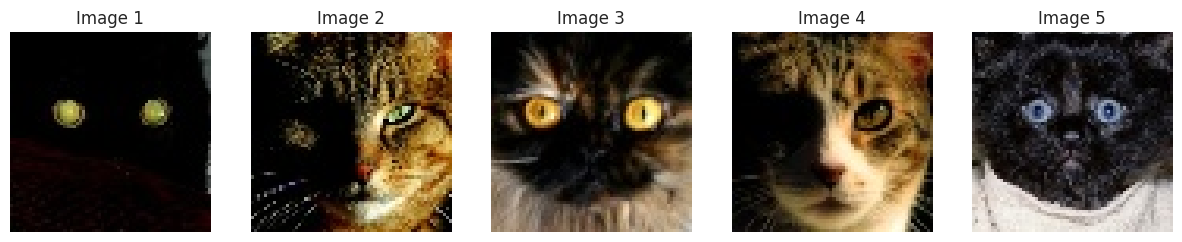

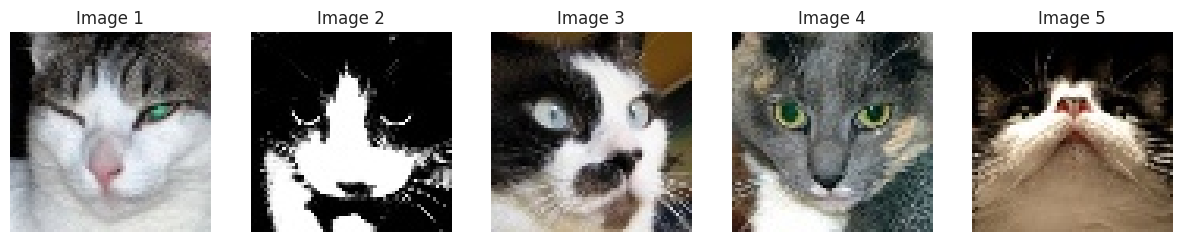

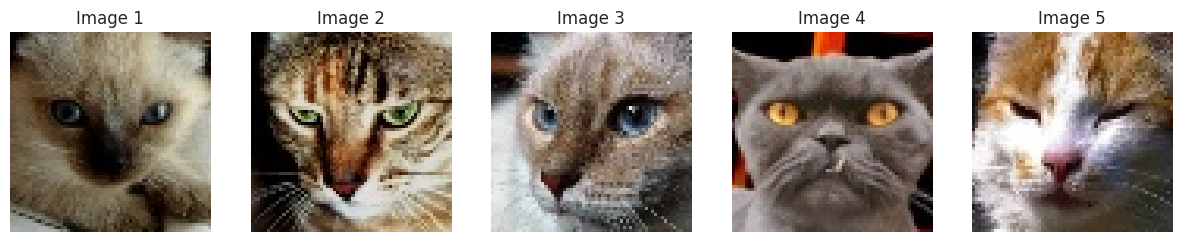

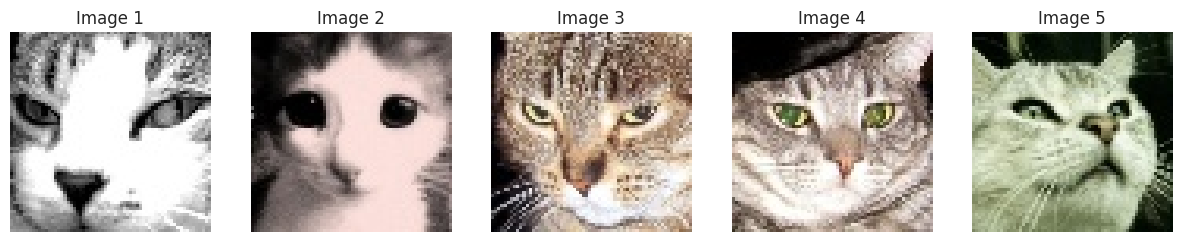

In [ ]:
# Определяем количество столбцов для изображений
num_cols = 5

for cluster in np.unique(y_pred):
    cluster_points = like_nn_projection[y_pred == cluster]
    cluster_answers = cats[y_pred == cluster]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем 5 изображений
    closest_answers = np.unique(cluster_answers[closest_idxs], axis=0)[:5]

    # Создаем новый график с пятью столбцами
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 3))

    # Выводим по 5 изображений для каждого кластера
    for i, im in enumerate(closest_answers):
        ax = axes[i]
        ax.imshow(im.reshape(64, 64, 3))
        ax.axis('off')  # Выключаем оси
        ax.set_title(f'Image {i+1}')  # Заголовок для каждого изображения

    plt.show()  # Показываем график после вывода всех изображений


Опишите отличительные черты кластеров:

По сути распределение по кластерам получилось практически тем же самым, что и в предыдущем пункте. А именно:

-- в 1 кластере в основном котики с темным окрасом, либо находящиеся в темноте

-- во 2 кластере в основном котики либо с рыжим окрасом, либо с полосатые

-- в 3 кластере в основном котики с белым пятном на мордочке или шее

-- в 4 кластере в основном котики с светло-серым или белым окрасом

Сильно ли они отличаются от предыдущего способа?

Из графиков PCA проекций изображений на плоскость и отображения 5 наиболее близкий элементов видно, что разница в распределении элементов по кластерам получилась минимальной. Можем предположить, что это связано с тем, что, как мы получили ранее, KDE-оценки для пространств котиков практически не меняются в зависимости от размерности. Так что изменив размерность мы получили примерно тот же результат.

#### 4. Нейросетевые эмбеддинги + кластеризация

Попробуем применить к изображениям такой же подход, как с текстами. То есть возьмем хорошую уже обученную нейросеть, получим с ее помощью эмбеддинги изображений и будем дулеть кластеризацию этих эмбеддингов.

Выберите на <a target="_blank" href="https://huggingface.co/models">huggingface</a> модель для получения эмбеддингов изображений.

**Примечания**
- Нам нужны `CV` модели для задачи извлечения признаков (в фильтрах huggingface называются `Image Feature Extraction`).
- Не выбирайте слишком тяжелые модели (с суффиксами `-huge`, `-giant`, `-large` и прочим), нам это ни к чему, так как картинки маленькие и простые. К тому же это замедлит предсказание эмбеддингов.
- Обычно в карточке модели есть пример применения, который можно скопировать и как в семинаре в цикле применить ко всем батчам изображениям.
- Некоторые модели могут возвращать не эмбеддинг размерности `(D,)`, а матрицу признаков размерности `(n, D)`, в этому случае надо применить average-pooling, усреднив по предпоследней оси.

Загрузите модель, примените к одному тестовому изображению кота и посмотрите на размерность полученного тензора

In [6]:
example_image = cats[0].reshape(64, 64, 3)

# Загрузка и тестовое применение модели
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=example_image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

last_hidden_states.shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

torch.Size([1, 197, 768])

Теперь примените загруженную модель ко всем картинкам

Предварительно уберем из каринок дубликаты и сделаем reshape()

In [7]:
reshaped_cats = cats.reshape(-1, 64, 64, 3)

In [8]:
emb_list = np.empty(shape=(0, 0))
batch_size = 128
model.to('cuda')
with torch.no_grad():
    model.eval()
    for i in tqdm(range(0, len(reshaped_cats), batch_size)):
        batch = reshaped_cats[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        last_hidden_states = np.average(outputs.last_hidden_state.cpu(), axis=1)

        if emb_list.size > 0:
            emb_list = np.concatenate((emb_list, last_hidden_states))
        else:
            emb_list = last_hidden_states


100%|██████████| 124/124 [04:28<00:00,  2.16s/it]


Сделайте кластеризацию полученных эмбеддингов

In [9]:
kmeans = KMeans(n_clusters=4, n_init="auto", random_state=42)
kmeans.fit(emb_list)
y_pred = kmeans.predict(emb_list)

# Делаем проекцию
pca = PCA(n_components=2)
like_nn_projection = pca.fit_transform(emb_list)

Визуализируйте полученные кластера:

In [10]:
visualize_images_clusterisation(images=cats, projection=like_nn_projection, clusters=y_pred)

<IPython.core.display.Javascript object>

Нарисуйте по 5-10 типичных изображений для новых кластеров

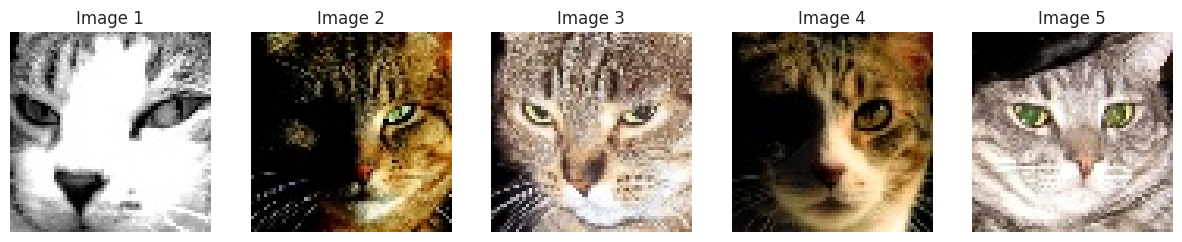

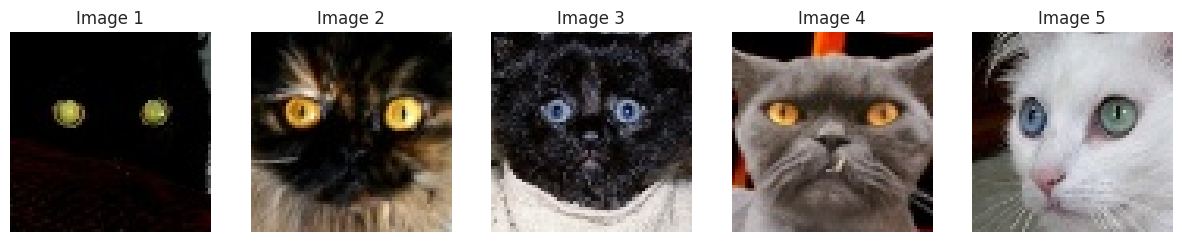

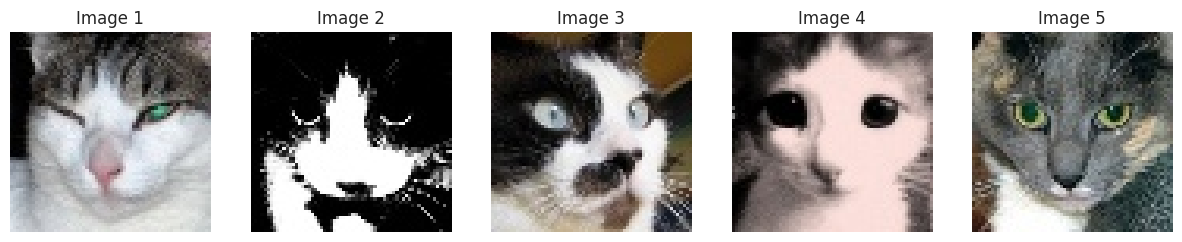

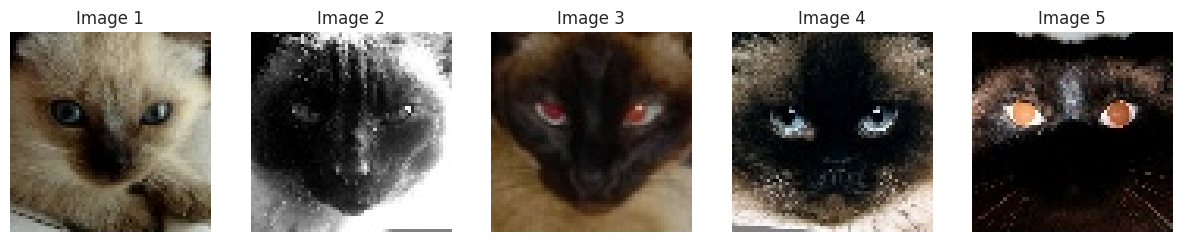

In [11]:
# Определяем количество столбцов для изображений
num_cols = 5

for cluster in np.unique(y_pred):
    cluster_points = like_nn_projection[y_pred == cluster]
    cluster_answers = cats[y_pred == cluster]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем 5 изображений
    closest_answers = np.unique(cluster_answers[closest_idxs], axis=0)[:5]

    # Создаем новый график с пятью столбцами
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 3))

    # Выводим по 5 изображений для каждого кластера
    for i, im in enumerate(closest_answers):
        ax = axes[i]
        ax.imshow(im.reshape(64, 64, 3))
        ax.axis('off')  # Выключаем оси
        ax.set_title(f'Image {i+1}')  # Заголовок для каждого изображения

    plt.show()  # Показываем график после вывода всех изображений


Опишите отличительные черты кластеров:

-- в 1 кластере в основном котики с рыжим окрасом, либо с полосатые

-- во 2 кластере в основном котики либо с темным окрасом, либо находящиеся в темноте

-- в 3 кластере в основном котики с белым пятном на мордочке или шее

-- в 4 кластере в основном котики с черным пятнышком на мордочке

Чем отличаются кластеры, полученные этим способом от первых двух?

В полученных кластерах появились котики с определенным окрасом в качестве отдельного кластера (кажется, в основном это сиамские). В остальном же кластера "по составу" получились близки к предыдущим результатам.

#### 5. Выводы
Сделайте выводы:

Из анализа KDE-оценки плотности мы сделали вывод, что для пространства котиков проклятие размерности не выполняется.

После этого мы проверили наше предположение на практике, рассмотрев использование kMeans и PCA в разных комбинациях и получив схожие результаты. Эксперименты показали, что наше предположение выполняется.

Также нам удалось воспользоваться уже готовой моделью для кластеризации котиков. Она показала чуть другие результаты при делении на кластеры, однако общая картина все равно получилась близкой. Возможно, можно получить еще более схожие результаты, если увеличить количество кластеров.